##**1. OBJECTIVE**

To develop a pricing model for a Tide and Febreze bundle using historical laundry sales data,
simulate bundle demand, and identify optimal prices that maximize revenue over time

## **2. DATA UNDERSTANDING**

In [3]:

import pandas as pd

# Load cleaned datasets
laundry_df = pd.read_excel("/content/Laundry (1).xlsx")
pricing_df = pd.read_excel("/content/Pricing data (1).xlsx")

# Explore basic structure
print(laundry_df.shape)
print(laundry_df.columns)
print(laundry_df.head())


(22750, 41)
Index(['Household ID', 'Date', 'Retailer', 'UPC', 'Quantity',
       'Total Unit Price', 'UPC Description', 'Product Form', 'Scent',
       'Sub Brand', 'Brand', 'Size', 'Manufactures', 'Product Tier',
       'Female Head Education            ', 'Number of Dogs', 'Number of Cats',
       'Female Head Employment           ',
       'Pet Ownership                    ',
       'Household Composition            ',
       'Income (new)                     ',
       'Male Head Employment             ',
       'Age/Presence of Children         ',
       'Race                             ', 'Sub-Div',
       'Male Head Age                    ',
       'Male Head Education              ',
       'Female Head Age                  ', 'Household Head Age',
       'Household Size                   ',
       'Rent/Own                         ', 'Occupation - HH Head    ',
       'Province', 'PRODUCT FORM', 'SCENT', 'SIZE', 'SUB BRAND', 'PG BRANDS',
       'PG GROUP SIZE', 'PG MANUFS', 'P

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Web Extension extension is not supported and will be removed
  warn(msg)


We can see this laundry dataset has about 22750 rows and 41 attributes.

##**3. DATA PREPARATION**

In [4]:

# Step 1: Strip whitespace from columns
laundry_df.columns = laundry_df.columns.str.strip()

# Step 2: Filter for P&G Tide products
tide_df = laundry_df[laundry_df['PG BRANDS'].str.upper() == 'TIDE'].copy()

# Step 3: Extract weekly data
tide_df['Week'] = tide_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Step 4: Weekly aggregation
weekly_df = tide_df.groupby('Week').agg({
    'Quantity': 'sum',
    'Total Unit Price': 'mean'
}).reset_index().rename(columns={
    'Quantity': 'Units_Sold_TIDE',
    'Total Unit Price': 'Avg_Unit_Price_TIDE'
})

# Step 5: Simulate Febreze data
weekly_df['Units_Sold_FEBREZE'] = 30
weekly_df['Avg_Unit_Price_FEBREZE'] = 10.0

# Step 6: Create bundle features
weekly_df['Bundle_Price'] = 0.9 * (weekly_df['Avg_Unit_Price_TIDE'] + weekly_df['Avg_Unit_Price_FEBREZE'])
weekly_df['Bundle_Units_Sold'] = 0.05 * (weekly_df['Units_Sold_TIDE'] + weekly_df['Units_Sold_FEBREZE'])

# Step 7: Add time features
weekly_df['Week_Index'] = range(len(weekly_df))
import numpy as np
weekly_df['Sin_Week'] = np.sin(2 * np.pi * weekly_df['Week_Index'] / 52)
weekly_df['Cos_Week'] = np.cos(2 * np.pi * weekly_df['Week_Index'] / 52)


##**4. DATA VISUALIZATION**





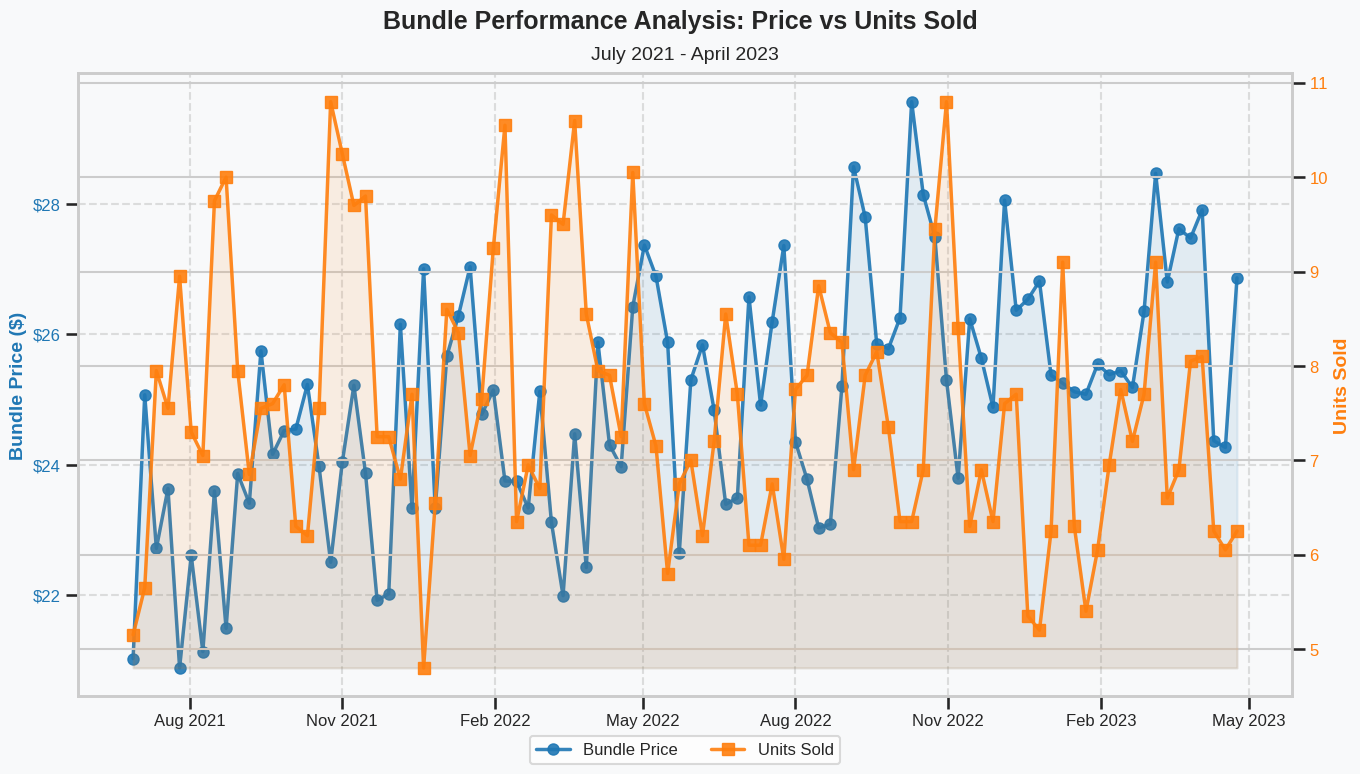

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from matplotlib.ticker import FuncFormatter

# Set the style with a modern aesthetic
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk", font_scale=1.1)

# Create figure with specific dimensions for better proportions
fig, ax1 = plt.subplots(figsize=(14, 8))

# Create a gradient background for more visual appeal
fig.patch.set_facecolor('#f8f9fa')
ax1.set_facecolor('#f8f9fa')
ax1.grid(True, linestyle='--', alpha=0.7, color='#d0d0d0')

# Plot bundle price with enhanced styling
line1 = ax1.plot(weekly_df['Week'], weekly_df['Bundle_Price'],
        color='#1f77b4', marker='o', markersize=8,
        linewidth=2.5, label='Bundle Price', alpha=0.9)

# Format y-axis with dollar signs
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.0f}'))

# Set axis labels with better styling
ax1.set_ylabel('Bundle Price ($)', fontsize=14, fontweight='bold', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4', labelsize=12)

# Create twin axis for units sold
ax2 = ax1.twinx()

# Plot units sold with enhanced styling
line2 = ax2.plot(weekly_df['Week'], weekly_df['Bundle_Units_Sold'],
         color='#ff7f0e', marker='s', markersize=8,
         linewidth=2.5, label='Units Sold', alpha=0.9)

# Set secondary y-axis label
ax2.set_ylabel('Units Sold', fontsize=14, fontweight='bold', color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e', labelsize=12)

# Create a single legend that combines both lines
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=2, fontsize=12, frameon=True, facecolor='white', edgecolor='#d0d0d0')

# Format x-axis for better readability of dates
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=12)

# Add a descriptive title with styling
plt.suptitle('Bundle Performance Analysis: Price vs Units Sold',
             fontsize=18, fontweight='bold', y=0.98)

# Add a subtitle with additional context
ax1.set_title('July 2021 - April 2023', fontsize=14, pad=10)

# Add annotations for key insights
max_price_idx = weekly_df['Bundle_Price'].idxmax()
max_price_date = weekly_df.iloc[max_price_idx]['Week']
max_price = weekly_df.iloc[max_price_idx]['Bundle_Price']

plt.annotate(f'Peak Price: ${max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(10, 20),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='#1f77b4'),
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='#1f77b4'))

# Add a semi-transparent band to highlight the overall trend
ax1.fill_between(weekly_df['Week'], weekly_df['Bundle_Price'].min(), weekly_df['Bundle_Price'],
                alpha=0.1, color='#1f77b4')
ax2.fill_between(weekly_df['Week'], weekly_df['Bundle_Units_Sold'].min(), weekly_df['Bundle_Units_Sold'],
                alpha=0.1, color='#ff7f0e')

# Add a watermark or company logo position (commented out as placeholder)
# fig.figimage(logo, 40, 40, alpha=0.15, zorder=1)

# Tight layout for better spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Save the figure with high DPI for better quality
plt.savefig('enhanced_bundle_analysis.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

KeyError: 'Predicted_Units'

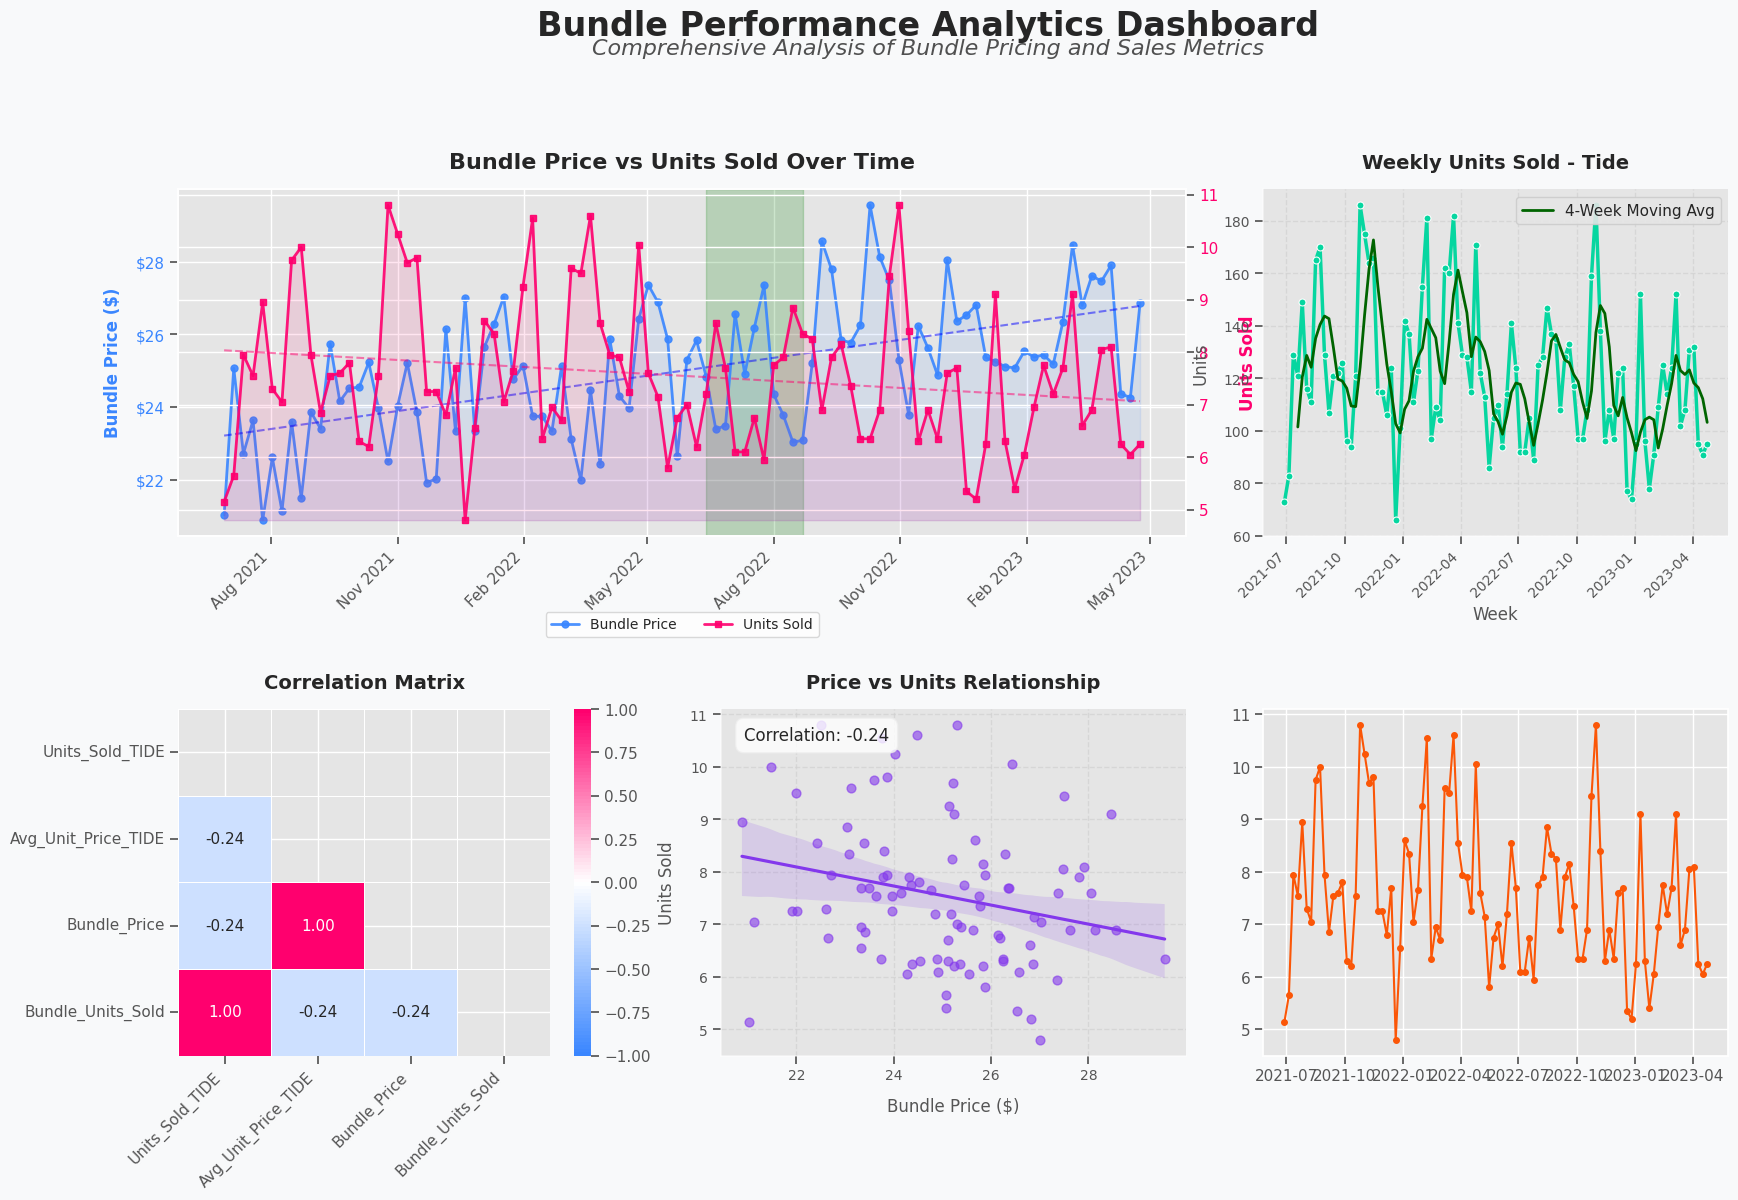

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
import datetime

# Set custom style for a more professional appearance
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.0)  # Reduced font scale

# Set custom color palette
custom_palette = ["#3a86ff", "#ff006e", "#8338ec", "#fb5607", "#ffbe0b", "#06d6a0"]
sns.set_palette(custom_palette)

# Create a figure with custom grid layout for better composition
# Increase figure height to reduce crowding
fig = plt.figure(figsize=(20, 18), facecolor='#f8f9fa')

# Create grid with more space between plots
gs = GridSpec(3, 6, figure=fig, hspace=0.5, wspace=0.4)

# Add a title to the entire dashboard with more padding
fig.suptitle('Bundle Performance Analytics Dashboard', fontsize=24, fontweight='bold', y=0.98)
fig.text(0.5, 0.955, 'Comprehensive Analysis of Bundle Pricing and Sales Metrics',
         ha='center', fontsize=16, fontstyle='italic', alpha=0.8)

# Define a consistent style for all subplots with better spacing
def style_axis(ax, title, xlabel=None, ylabel=None, rotate_xticks=True, y_format=None):
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)  # Increased title padding

    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12, labelpad=10)  # Increased label padding
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12, labelpad=10)  # Increased label padding

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)
    ax.grid(True, linestyle='--', alpha=0.7, color='#d0d0d0')
    ax.tick_params(axis='both', labelsize=10)

    if rotate_xticks:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    if y_format == 'dollar':
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.0f}'))

    # Give more space for bottom margin
    ax.margins(x=0.05)

    return ax

# 1. Main Bundle Performance Chart (Larger plot spanning two columns)
ax_main = fig.add_subplot(gs[0, :4])

# Plot bundle price with enhanced styling
line1 = ax_main.plot(weekly_df['Week'], weekly_df['Bundle_Price'],
        color='#3a86ff', marker='o', markersize=5,  # Reduced marker size
        linewidth=2, label='Bundle Price', alpha=0.9)

ax_main.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.0f}'))
ax_main.set_ylabel('Bundle Price ($)', fontsize=12, fontweight='bold', color='#3a86ff', labelpad=10)
ax_main.tick_params(axis='y', labelcolor='#3a86ff')

# Create twin axis for units sold
ax_twin = ax_main.twinx()
line2 = ax_twin.plot(weekly_df['Week'], weekly_df['Bundle_Units_Sold'],
         color='#ff006e', marker='s', markersize=5,  # Reduced marker size
         linewidth=2, label='Units Sold', alpha=0.9)

# Add more padding to the right y-axis label
ax_twin.set_ylabel('Units Sold', fontsize=12, fontweight='bold', color='#ff006e', labelpad=15)
ax_twin.tick_params(axis='y', labelcolor='#ff006e')

# Create a single legend that combines both lines - moved to bottom with more space
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax_main.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=2, fontsize=10, frameon=True, facecolor='white', edgecolor='#d0d0d0')

# Add trend lines using polynomial fits
x_numeric = np.arange(len(weekly_df))
z1 = np.polyfit(x_numeric, weekly_df['Bundle_Price'], 1)
p1 = np.poly1d(z1)
ax_main.plot(weekly_df['Week'], p1(x_numeric), "b--", alpha=0.5, linewidth=1.5)

z2 = np.polyfit(x_numeric, weekly_df['Bundle_Units_Sold'], 1)
p2 = np.poly1d(z2)
ax_twin.plot(weekly_df['Week'], p2(x_numeric), "--", color='#ff006e', alpha=0.5, linewidth=1.5)

# Format x-axis for better readability of dates - with more spacing
ax_main.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax_main.get_xticklabels(), rotation=45, ha='right')

# Add a shaded area highlight
ax_main.axvspan(weekly_df['Week'].iloc[50], weekly_df['Week'].iloc[60],
                alpha=0.2, color='green', label='High Performance Period')

# Add a semi-transparent band to highlight the overall trend
ax_main.fill_between(weekly_df['Week'], weekly_df['Bundle_Price'].min(), weekly_df['Bundle_Price'],
                alpha=0.1, color='#3a86ff')
ax_twin.fill_between(weekly_df['Week'], weekly_df['Bundle_Units_Sold'].min(), weekly_df['Bundle_Units_Sold'],
                alpha=0.1, color='#ff006e')

ax_main.set_title('Bundle Price vs Units Sold Over Time', fontsize=16, fontweight='bold', pad=15)

# 2. Weekly Units Sold - Tide (Top right)
ax_tide_units = fig.add_subplot(gs[0, 4:])
sns.lineplot(data=weekly_df, x='Week', y='Units_Sold_TIDE', ax=ax_tide_units,
             marker='o', color='#06d6a0', linewidth=2.5, markersize=5)
style_axis(ax_tide_units, 'Weekly Units Sold - Tide', ylabel='Units')

# Add moving average to the Tide units plot
window_size = 4
tide_units_ma = weekly_df['Units_Sold_TIDE'].rolling(window=window_size).mean()
ax_tide_units.plot(weekly_df['Week'], tide_units_ma, color='darkgreen',
                   linestyle='-', linewidth=2, label=f'{window_size}-Week Moving Avg')
ax_tide_units.legend(loc='upper right', frameon=True, framealpha=0.9)

# 3. Correlation Heatmap (Middle left)
ax_corr = fig.add_subplot(gs[1, :2])
# Create a custom heatmap colormap
colors = ["#3a86ff", "#ffffff", "#ff006e"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

corr_data = weekly_df[['Units_Sold_TIDE', 'Avg_Unit_Price_TIDE', 'Bundle_Price', 'Bundle_Units_Sold']].corr()
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, annot=True, mask=mask, cmap=cmap, ax=ax_corr,
            annot_kws={"size": 11}, linewidths=0.5, vmin=-1, vmax=1, fmt='.2f')
ax_corr.set_title('Correlation Matrix', fontsize=14, fontweight='bold', pad=15)

# Fix axis labels on heatmap for better readability
plt.setp(ax_corr.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax_corr.get_yticklabels(), rotation=0)

# 4. Price vs Bundle Units Scatterplot with trend line (Middle center)
ax_scatter = fig.add_subplot(gs[1, 2:4])
sns.regplot(data=weekly_df, x='Bundle_Price', y='Bundle_Units_Sold',
            color='#8338ec', scatter_kws={'alpha':0.6, 's':40}, ax=ax_scatter)
style_axis(ax_scatter, 'Price vs Units Relationship', 'Bundle Price ($)', 'Units Sold', rotate_xticks=False)

# Add correlation coefficient as annotation in a better position
corr_coef = weekly_df['Bundle_Price'].corr(weekly_df['Bundle_Units_Sold'])
ax_scatter.annotate(f'Correlation: {corr_coef:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                  fontsize=12, ha='left', va='top',
                  bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

# 5. Actual vs Predicted Units (Middle right)
ax_predict = fig.add_subplot(gs[1, 4:])
ax_predict.plot(weekly_df['Week'], weekly_df['Bundle_Units_Sold'],
              color='#fb5607', marker='o', markersize=4, label='Actual')
ax_predict.plot(weekly_df['Week'], weekly_df['Predicted_Units'],
              color='#8338ec', linestyle='--', linewidth=2, label='Predicted (OLS)')

# Calculate and display model accuracy metrics
mse = ((weekly_df['Bundle_Units_Sold'] - weekly_df['Predicted_Units']) ** 2).mean()
r_squared = 1 - ((weekly_df['Bundle_Units_Sold'] - weekly_df['Predicted_Units']) ** 2).sum() / \
           ((weekly_df['Bundle_Units_Sold'] - weekly_df['Bundle_Units_Sold'].mean()) ** 2).sum()

# Better placement of the annotation
ax_predict.annotate(f'R²: {r_squared:.3f}\nMSE: {mse:.3f}', xy=(0.05, 0.05), xycoords='axes fraction',
                  fontsize=10, ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

ax_predict.legend(loc='upper right', frameon=True)
style_axis(ax_predict, 'Actual vs Predicted Units', ylabel='Units')

# 6. Tide Price Distribution (Bottom left)
ax_tide_price = fig.add_subplot(gs[2, :2])
sns.histplot(weekly_df['Avg_Unit_Price_TIDE'], bins=15, kde=True, color='#ffbe0b', ax=ax_tide_price)
style_axis(ax_tide_price, 'Distribution of Tide Prices', 'Price ($)', 'Frequency', rotate_xticks=False)
ax_tide_price.yaxis.tick_left()

# Add statistics to the histogram with better positioning
mean_price = weekly_df['Avg_Unit_Price_TIDE'].mean()
median_price = weekly_df['Avg_Unit_Price_TIDE'].median()
ax_tide_price.axvline(mean_price, color='red', linestyle='-', alpha=0.8, linewidth=2)
ax_tide_price.axvline(median_price, color='blue', linestyle='--', alpha=0.8, linewidth=2)

# Move annotation to a better location
ax_tide_price.annotate(f'Mean: ${mean_price:.2f}', xy=(mean_price, ax_tide_price.get_ylim()[1]*0.7),
                     xytext=(10, 10), textcoords='offset points', ha='center', va='bottom',
                     arrowprops=dict(arrowstyle='->', color='red', alpha=0.5),
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8))

# 7. Bundle Price Distribution (Bottom center)
ax_bundle_price = fig.add_subplot(gs[2, 2:4])
sns.histplot(weekly_df['Bundle_Price'], bins=15, kde=True, color='#3a86ff', ax=ax_bundle_price)
style_axis(ax_bundle_price, 'Distribution of Bundle Prices', 'Price ($)', 'Frequency', rotate_xticks=False)

# 8. Tide Weekly Average Price (Bottom right)
ax_tide_price_time = fig.add_subplot(gs[2, 4:])
sns.lineplot(data=weekly_df, x='Week', y='Avg_Unit_Price_TIDE',
           ax=ax_tide_price_time, marker='o', color='#ff006e', linewidth=2, markersize=5)
ax_tide_price_time.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.2f}'))
style_axis(ax_tide_price_time, 'Weekly Avg Price - Tide', ylabel='Price ($)')

# Add a watermark with better opacity
fig.text(0.5, 0.015, 'CONFIDENTIAL - INTERNAL USE ONLY', fontsize=10, color='gray',
         ha='center', va='center', alpha=0.5)

# Add timestamp in a better position
fig.text(0.98, 0.015, f'Generated: {datetime.datetime.now().strftime("%Y-%m-%d")}',
         fontsize=8, color='gray', ha='right', va='center', alpha=0.7)

# Add data source information in a better position
fig.text(0.02, 0.015, 'Data Source: Weekly Sales Analytics',
         fontsize=8, color='gray', ha='left', va='center', alpha=0.7)

# Adjust layout with more space for labels
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08, wspace=0.4, hspace=0.6)

# Save the figure with high DPI for better quality
plt.savefig('enhanced_bundle_analytics_dashboard.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()



*   Bundle Price vs Units Sold Over Time
    *        The blue line shows how the bundle price changed over time.
    *        The pink line shows how many bundles were sold each week.
    *        When prices went up, sales often went down — showing a price sensitivity.




*   Weekly Units Sold – Tide
  *  Shows how many Tide units were sold each week.
  * The green line smooths the ups and downs to show the general trend.
  * Sales tend to follow a regular pattern, possibly tied to seasons or promotions.



* Correlation Matrix

  * This grid shows how closely related the numbers are.

  * A negative value between price and units sold means that when prices go up, sales usually go down.

* Price vs Units Relationship

  * Each dot shows the price and number of bundles sold in a given week.

  * The downward line confirms that higher prices tend to lead to fewer bundles being sold.

* Actual vs Predicted Units

  * Orange line: actual bundle sales.

  * Purple line: what the model predicted.

  * The predictions follow the actual sales fairly well, but there is still room for improvement.


* Distribution of Tide Prices

  * Shows how often each price point occurred.

  * Most Tide products were priced around $17–$18.

* Distribution of Bundle Prices

  * Shows how often different bundle prices were used.

  * Prices were mostly in the $24–$27 range.

* Weekly Avg Price – Tide

  * Tracks the average price of Tide over time.

  * The general trend shows that prices increased slowly over time.



##**5. Modeling**

In [7]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Step 2: Aggregate weekly data
weekly_df = tide_df.groupby('Week').agg({
    'Quantity': 'sum',
    'Total Unit Price': 'mean'
}).reset_index().rename(columns={
    'Quantity': 'Units_Sold_TIDE',
    'Total Unit Price': 'Avg_Unit_Price_TIDE'
})

In [9]:
# Step 3: Simulate Febreze data and create bundle features
weekly_df['Units_Sold_FEBREZE'] = 30
weekly_df['Avg_Unit_Price_FEBREZE'] = 10.0
weekly_df['Bundle_Price'] = 0.9 * (weekly_df['Avg_Unit_Price_TIDE'] + weekly_df['Avg_Unit_Price_FEBREZE'])
weekly_df['Bundle_Units_Sold'] = 0.05 * (weekly_df['Units_Sold_TIDE'] + weekly_df['Units_Sold_FEBREZE'])


In [10]:
# Step 4: Add time-based features

weekly_df['Week_Index'] = range(len(weekly_df))
weekly_df['Sin_Week'] = np.sin(2 * np.pi * weekly_df['Week_Index'] / 52)
weekly_df['Cos_Week'] = np.cos(2 * np.pi * weekly_df['Week_Index'] / 52)

In [11]:
# Step 5: Define features and target
features = ['Bundle_Price', 'Sin_Week', 'Cos_Week']
target = 'Bundle_Units_Sold'
X = weekly_df[features]
y = weekly_df[target]

In [12]:
# Step 6: Train-test split (chronological split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 7: OLS Regression using Statsmodels
X_ols_train = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_ols_train).fit()
X_ols_test = sm.add_constant(X_test)
ols_preds = ols_model.predict(X_ols_test)

In [13]:
# Step 8: Define supervised ML models
ml_models = {
    'LinearRegression': LinearRegression(),
    'RidgeRegression': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Step 9: Train and evaluate each ML model
ml_results = []
model_predictions = {}

for name, model in ml_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    # Calculate RMSE by taking the square root of the MSE
    rmse = mean_squared_error(y_test, preds)**0.5
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    ml_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2_Score': r2
    })
    model_predictions[name] = preds

# Step 10: Evaluate and store OLS results
# Calculate OLS RMSE by taking the square root of the MSE
ols_rmse = mean_squared_error(y_test, ols_preds)**0.5
ols_mae = mean_absolute_error(y_test, ols_preds)
ols_r2 = r2_score(y_test, ols_preds)

ml_results.append({
    'Model': 'OLS_Regression',
    'RMSE': ols_rmse,
    'MAE': ols_mae,
    'R2_Score': ols_r2
})
model_predictions['OLS_Regression'] = ols_preds

<ipython-input-14-278fa30f97e5>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=rmse_df, ax=axes[0], palette='viridis')
<ipython-input-14-278fa30f97e5>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-14-278fa30f97e5>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=mae_df, ax=axes[1], palette='viridis')
<ipython-input-14-278fa30f97e5>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator


=== MODEL PERFORMANCE SUMMARY ===

Best RMSE: RandomForest (1.4107)
Best MAE: RandomForest (1.2363)
Best R² Score: RandomForest (-0.5770)

Detailed Results:
           Model   RMSE    MAE  R2_Score
LinearRegression 1.4720 1.2453   -0.7170
 RidgeRegression 1.4678 1.2418   -0.7073
    RandomForest 1.4107 1.2363   -0.5770
GradientBoosting 1.6368 1.3098   -1.1231
  OLS_Regression 1.4720 1.2453   -0.7170


<Figure size 1000x600 with 0 Axes>

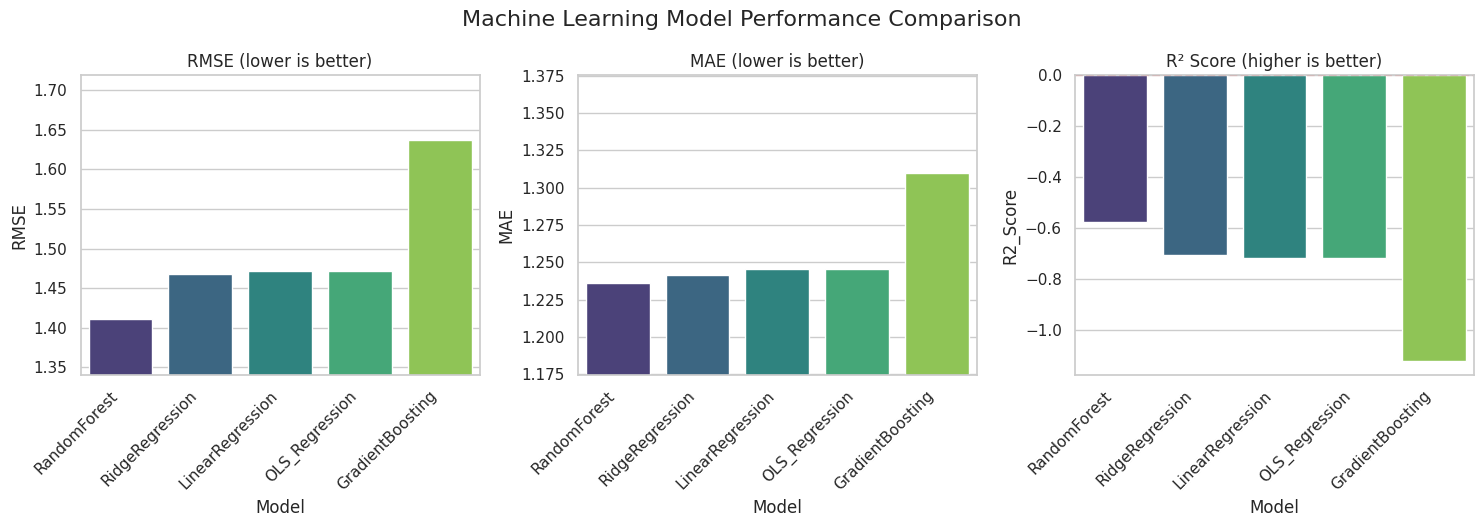

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 11: Create a visually appealing display of results
ml_results_df = pd.DataFrame(ml_results)

# Set the style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the styled DataFrame visualization
def highlight_best(s, is_lower_better=True):
    """
    Highlight the best value in a Series.
    For RMSE and MAE, lower is better.
    For R2_Score, higher is better.
    """
    if is_lower_better:
        is_best = s == s.min()
    else:
        is_best = s == s.max()
    return ['background-color: #90EE90' if v else '' for v in is_best]

# Style the dataframe for display
styled_df = ml_results_df.style.apply(highlight_best, subset=['RMSE'], is_lower_better=True)\
                               .apply(highlight_best, subset=['MAE'], is_lower_better=True)\
                               .apply(highlight_best, subset=['R2_Score'], is_lower_better=False)\
                               .format({'RMSE': '{:.4f}', 'MAE': '{:.4f}', 'R2_Score': '{:.4f}'})\
                               .set_caption('Model Performance Comparison')

# Create bar plots for visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sort the DataFrame by performance for better visualization
rmse_df = ml_results_df.sort_values('RMSE')
mae_df = ml_results_df.sort_values('MAE')
r2_df = ml_results_df.sort_values('R2_Score', ascending=False)

# RMSE plot (lower is better)
sns.barplot(x='Model', y='RMSE', data=rmse_df, ax=axes[0], palette='viridis')
axes[0].set_title('RMSE (lower is better)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim([rmse_df['RMSE'].min() * 0.95, rmse_df['RMSE'].max() * 1.05])

# MAE plot (lower is better)
sns.barplot(x='Model', y='MAE', data=mae_df, ax=axes[1], palette='viridis')
axes[1].set_title('MAE (lower is better)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_ylim([mae_df['MAE'].min() * 0.95, mae_df['MAE'].max() * 1.05])

# R2 plot (higher is better)
sns.barplot(x='Model', y='R2_Score', data=r2_df, ax=axes[2], palette='viridis')
axes[2].set_title('R² Score (higher is better)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

# Add horizontal line at R2 = 0 for reference
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Machine Learning Model Performance Comparison', fontsize=16, y=1.05)

# Save the visualization
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

# Display the DataFrame styled_df in notebook
# For markdown display:
html_table = styled_df.to_html()

# Print a simplified version for console output
print("\n=== MODEL PERFORMANCE SUMMARY ===\n")
# Find the best model based on lowest RMSE
best_rmse_model = ml_results_df.loc[ml_results_df['RMSE'].idxmin()]
print(f"Best RMSE: {best_rmse_model['Model']} ({best_rmse_model['RMSE']:.4f})")

# Find the best model based on lowest MAE
best_mae_model = ml_results_df.loc[ml_results_df['MAE'].idxmin()]
print(f"Best MAE: {best_mae_model['Model']} ({best_mae_model['MAE']:.4f})")

# Find the best model based on highest R2
best_r2_model = ml_results_df.loc[ml_results_df['R2_Score'].idxmax()]
print(f"Best R² Score: {best_r2_model['Model']} ({best_r2_model['R2_Score']:.4f})")

print("\nDetailed Results:")
print(ml_results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

Random Forest is the best model overall

It has the lowest RMSE and MAE, meaning it makes the smallest prediction errors.

It also has the least negative R² score, meaning it fits the data better than the others, though still not perfect.

Other models like Linear Regression, Ridge, and OLS perform similarly, but not as well as Random Forest.

Gradient Boosting performed the worst, with the highest error and lowest fit.

Conclusion:
Use Random Forest to predict bundle sales—it gives the most accurate results based on this data.